## 데이터 불러오기

In [5]:
from datasets import load_dataset

In [6]:
data_files = {"train": "/home/public/yunvqa/vcr/dataloaders/VCR_train.json", "test": "/home/public/yunvqa/vcr/dataloaders/VCR_val.json"}

squad_it_dataset = load_dataset("json", data_files=data_files)
squad_it_dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'question', 'label', 'explanation'],
        num_rows: 212923
    })
    test: Dataset({
        features: ['image_id', 'question', 'label', 'explanation'],
        num_rows: 26534
    })
})

In [8]:
squad_it_dataset['train'][0]

{'image_id': '/home/public/yunvqa/vcr/dataset/vcr1images/lsmdc_3015_CHARLIE_ST_CLOUD/3015_CHARLIE_ST_CLOUD_00.23.57.935-00.24.00.783@0.jpg',
 'question': 'Does person feel comfortable ? ',
 'label': {'ids': ['Yes because the person sitting next to her is smiling . ',
   'No she does not . ',
   'Yes , she is wearing something with thin straps . ',
   'Yes , she is cold . '],
  'weights': [0.30000001192092896,
   1.0,
   0.30000001192092896,
   0.30000001192092896]},
 'explanation': {'ids': ['There is snow on the ground , and she is wearing a coat and hate . ',
   'She is standing with her arms crossed and looks disturbed . ',
   'She is sitting very rigidly and tensely on the edge of the bed . her posture is not relaxed and her face looks serious . ',
   'person is laying in bed but not sleeping . she looks sad and is curled into a ball . '],
  'weights': [0.30000001192092896,
   1.0,
   0.30000001192092896,
   0.30000001192092896]}}

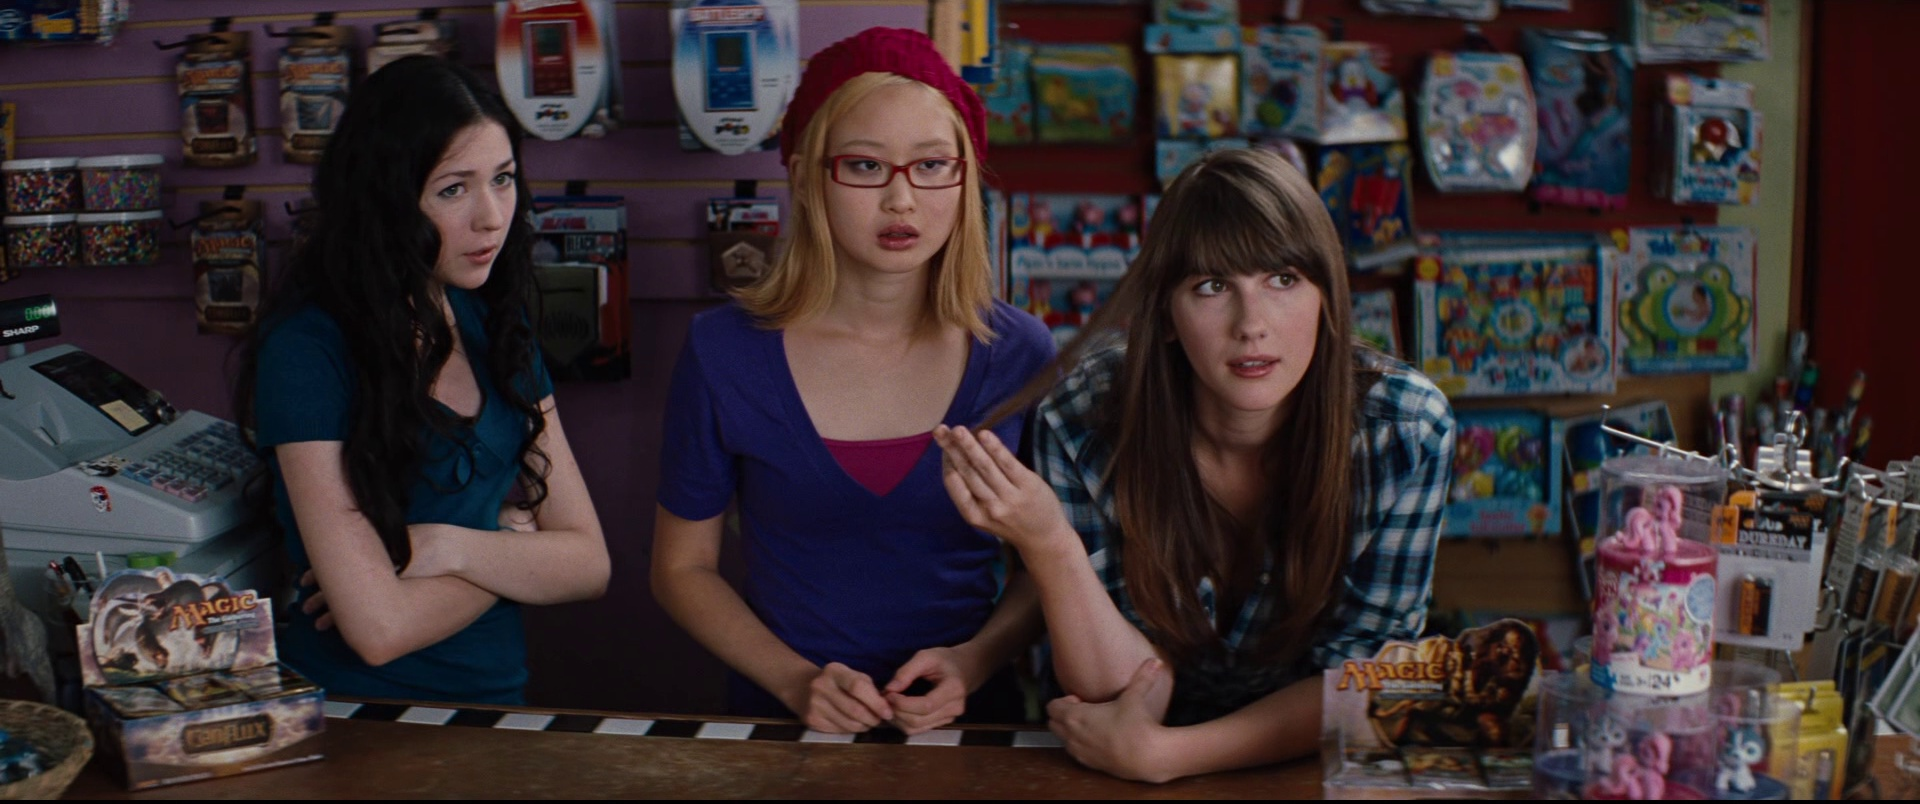

In [10]:
from PIL import Image

image = Image.open(squad_it_dataset['train'][0]['image_id'])
image

In [11]:
import itertools

labels = [item['ids'] for item in squad_it_dataset['train']['label']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()} 

In [15]:
def replace_ids(inputs):
  inputs["label"]["ids"] = [label2id[x] for x in inputs["label"]["ids"]]
  return inputs


train_dataset = squad_it_dataset['train'].map(replace_ids)
#test_dataset = squad_it_dataset['test'].map(replace_ids)
train_flat_dataset = train_dataset.flatten()
#test_flat_dataset = test_dataset.flatten()
train_flat_dataset.features

{'image_id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'label.ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'label.weights': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'explanation.ids': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'explanation.weights': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

## 데이터 전처리

In [16]:
model_checkpoint = "dandelin/vilt-b32-mlm"

In [17]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained(model_checkpoint)

In [18]:
import torch

def preprocess_data(examples):
    image_paths = examples['image_id']
    images = [Image.open(image_path) for image_path in image_paths]
    texts = examples['question']    

    encoding = processor(images, texts, padding="max_length", truncation=True, return_tensors="pt")

    for k, v in encoding.items():
          encoding[k] = v.squeeze()
    targets = []

    for labels, scores in zip(examples['label.ids'], examples['label.weights']):
        target = torch.zeros(len(id2label))

        for label, score in zip(labels, scores):
            target[label] = score
        targets.append(target)

    encoding["labels"] = targets
    return encoding

In [20]:
processed_dataset = train_flat_dataset.map(preprocess_data, batched=True, remove_columns=['question', 'image_id', 'label.ids', 'label.weights', 'explanation.ids', 'explanation.weights'])
processed_dataset

Map:   0%|          | 0/212923 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [10]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## 모델 훈련하기

In [11]:
from transformers import ViltForQuestionAnswering

model = ViltForQuestionAnswering.from_pretrained(model_checkpoint, num_labels=len(id2label), id2label=id2label, label2id=label2id)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.0.weight', 'classifier.1.weight', 'classifier.1.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments

repo_id = "MariaK/vilt_finetuned_200"

training_args = TrainingArguments(
    output_dir=repo_id,
    per_device_train_batch_size=4,
    num_train_epochs=20,
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False
)

In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
    tokenizer=processor,
)

In [16]:
trainer.train() 

/home/public/yunvqa/anaconda3/envs/XLNet/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


## 추론하기

In [ ]:
from transformers import pipeline

pipe = pipeline("visual-question-answering", model="MariaK/vilt_finetuned_200")

In [ ]:
example = dataset[0]
image = Image.open(example['image_id'])
question = example['question']
print(question)
pipe(image, question, top_k=1)

In [ ]:
processor = ViltProcessor.from_pretrained("MariaK/vilt_finetuned_200")

image = Image.open(example['image_id'])
question = example['question']

# prepare inputs
inputs = processor(image, question, return_tensors="pt")

model = ViltForQuestionAnswering.from_pretrained("MariaK/vilt_finetuned_200")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])